# Testing Trained model for Flower Classification

In [1]:
import numpy as np
import torch
from imageio import imread
from matplotlib import pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet152
from tqdm import tqdm

In [2]:
# PATH_TO_PRETRAINED_WEIGHTS = 'resnet_model_weight_for_cnc_BatchSize64_Iterations400_lr1e-5.pth'
PATH_TO_PRETRAINED_WEIGHTS = "resnet_model_weight_for_Flowers_Without_Weight_Freeze.pth"
CUDA_DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 1

In [3]:
transform_function = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [4]:
dataset_for_flower_testing = ImageFolder(
    root="FlowerClassificationTest_Archive/flowers",
    transform=transform_function,
)

In [5]:
dataset_for_flower_testing.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [6]:
dataloader_for_flower_testing = DataLoader(
    dataset=dataset_for_flower_testing, batch_size=BATCH_SIZE, shuffle=False
)

In [7]:
flower_classes = ["daisy", "dandelion", "rose", "sunflower", "tulip"]

In [8]:
resnet_model_for_cnc = resnet152()

In [9]:
resnet_model_for_cnc.requires_grad_(requires_grad=False)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# resnet_model_for_cnc.fc.requires_grad_(requires_grad = True)

In [11]:
resnet_model_for_cnc.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.2),
    torch.nn.Linear(
        in_features=512,
        out_features=5,
    ),
    torch.nn.Softmax(dim=1),
)

In [12]:
resnet_model_for_cnc.load_state_dict(
    torch.load(PATH_TO_PRETRAINED_WEIGHTS, map_location=CUDA_DEVICE)
)

<All keys matched successfully>

In [13]:
resnet_model_for_cnc.to(device=CUDA_DEVICE)
resnet_model_for_cnc.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
actual_label = []
predicted_label = []
for test_image, test_target in tqdm(dataloader_for_flower_testing):
    predicted_output = resnet_model_for_cnc(test_image.to(device=CUDA_DEVICE))
    predicted_class = torch.argmax(predicted_output, dim=1)

    actual_label.append(test_target.item())
    predicted_label.append(predicted_class.item())

100%|███████████████████████████████████████| 4317/4317 [01:06<00:00, 65.30it/s]


In [15]:
confusion_matrix_for_flower_classification = confusion_matrix(
    actual_label,
    predicted_label,
    # labels = dataset_for_flower_testing.classes
)

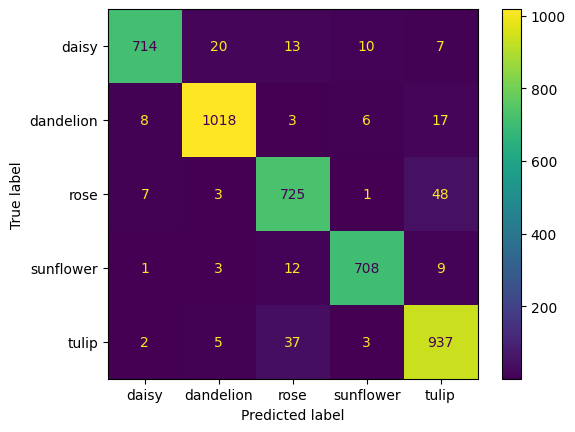

In [16]:
ConfusionMatrixDisplay(
    confusion_matrix_for_flower_classification,
    display_labels=dataset_for_flower_testing.classes,
).plot()
plt.show()

In [17]:
precision_recall_fscore_support(
    actual_label,
    predicted_label,
)

(array([0.97540984, 0.97044805, 0.91772152, 0.97252747, 0.92043222]),
 array([0.93455497, 0.96768061, 0.9247449 , 0.96589359, 0.95223577]),
 array([0.95454545, 0.96906235, 0.92121982, 0.96919918, 0.93606394]),
 array([ 764, 1052,  784,  733,  984]))

In [18]:
print(
    classification_report(
        y_true=actual_label,
        y_pred=predicted_label,
        target_names=dataset_for_flower_testing.classes,
    )
)

              precision    recall  f1-score   support

       daisy       0.98      0.93      0.95       764
   dandelion       0.97      0.97      0.97      1052
        rose       0.92      0.92      0.92       784
   sunflower       0.97      0.97      0.97       733
       tulip       0.92      0.95      0.94       984

    accuracy                           0.95      4317
   macro avg       0.95      0.95      0.95      4317
weighted avg       0.95      0.95      0.95      4317



In [19]:
PATH_TO_AN_IMAGE = (
    "FlowerClassificationTest_Archive/flowers/daisy/525780443_bba812c26a_m.jpg"
)

In [20]:
input_image = imread(PATH_TO_AN_IMAGE)

/tmp/ipykernel_55725/2966421094.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image = imread(PATH_TO_AN_IMAGE)


In [21]:
input_image.shape

(221, 240, 3)

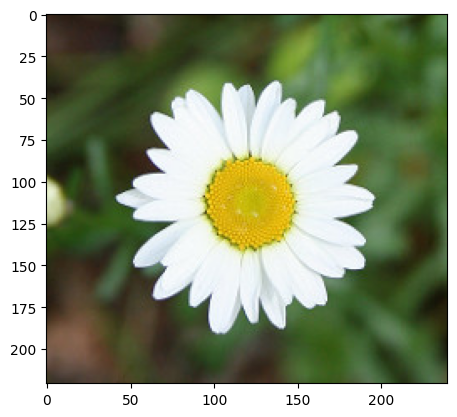

In [22]:
plt.imshow(input_image)
plt.show()

In [23]:
transformed_image = transform_function(input_image)

In [24]:
transformed_image.shape

torch.Size([3, 224, 224])

In [25]:
transformed_image = transformed_image.unsqueeze(dim=0)

In [26]:
transformed_image.dtype

torch.float32

In [27]:
predicted_output = resnet_model_for_cnc(transformed_image.to(device=CUDA_DEVICE))

In [28]:
flower_classes[torch.argmax(predicted_output, dim=1).item()]

'daisy'

In [29]:
predicted_output

tensor([[1.0000e+00, 2.7493e-13, 3.4503e-16, 2.0860e-13, 7.0399e-14]],
       device='cuda:1', grad_fn=<SoftmaxBackward0>)